**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


# Part I: Bag-of-Words Model

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/bow_guide.ipynb](guides/bow_guide.ipynb)


***

<br>

* Note that you should report results using a classification report. 

* Also, remember to include some reflections on your results: Are there any hyperparameters that are particularly important?

* You should follow the steps given in the `bow_guide` notebook

<br>

***

In [ ]:
# imports for the project

import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### 1. Load the data

We can load this data directly from [Hugging Face Datasets](https://huggingface.co/docs/datasets/) - The HuggingFace Hub- into a Pandas DataFrame. Pretty neat!

**Note**: This cell will download the dataset and keep it in memory. If you run this cell multiple times, it will download the dataset multiple times.

You are welcome to increase the `frac` parameter to load more data.

In [3]:

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}

train = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])
test = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["test"])

print(train.shape, test.shape)

(120000, 2) (7600, 2)


In [4]:

label_map = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}

def preprocess(df: pd.DataFrame, frac : float = 1e-2, label_map : dict[int, str] = label_map, seed : int = 42) -> pd.DataFrame:
    """ Preprocess the dataset 

    Operations:
    - Map the label to the corresponding category
    - Filter out the labels not in the label_map
    - Sample a fraction of the dataset (stratified by label)

    Args:
    - df (pd.DataFrame): The dataset to preprocess
    - frac (float): The fraction of the dataset to sample in each category
    - label_map (dict): A mapping of the original label to the new label
    - seed (int): The random seed for reproducibility

    Returns:
    - pd.DataFrame: The preprocessed dataset
    """

    return  (
        df
        .assign(label=lambda x: x['label'].map(label_map))
        [lambda df: df['label'].isin(label_map.values())]
        .groupby('label')[["text", "label"]]
        .apply(lambda x: x.sample(frac=frac, random_state=seed))
        .reset_index(drop=True)

    )

train_df = preprocess(train, frac=0.01)
test_df = preprocess(test, frac=0.1)

# clear up some memory by deleting the original dataframes
del train
del test

train_df.shape, test_df.shape

((1200, 2), (760, 2))

In [9]:
print(train_df.head())

                                                text     label
0  US house sales fall in July Sales of non-new h...  Business
1  DJ to acquire MarketWatch Dow Jones  amp; Co.,...  Business
2  Dollar hits new low on Snow speech The United ...  Business
3  Yukos executives 'flee' Russia All the top exe...  Business
4  Smithfield quarterly profits beat outlook SMIT...  Business


In [117]:
def build_document_term_matrix(preprocessed_documents):
    """
    Builds a Bag-of-Words document-term matrix.
    Returns:
    - document_term_matrix (list of lists): BoW representation of documents
    - vocab (list): Sorted vocabulary of unique words
    - word_to_index (dict): Mapping of word → index in vocabulary
    """
    # 1. Extract unique vocabulary from the dataset and sort it
    vocab = sorted(set(word for doc in preprocessed_documents for word in doc))

    # 2. Create a word-to-index mapping
    word_to_index = {word: idx for idx, word in enumerate(vocab)}

    print(word_to_index)

    # 3. Convert each document into a vector
    document_term_matrix = []
    
    for tokens in preprocessed_documents:
        doc_vector = [0] * len(vocab)  # Initialize a vector of zeros
        for token in tokens:
            if token in word_to_index:
                doc_vector[word_to_index[token]] += 1  # Increment word count
        document_term_matrix.append(doc_vector)

    print(f"\nVocabulary Size: {len(vocab)} | Number of Documents: {len(document_term_matrix)}\n")
    # Print vectors for first two sentences 
    #for i, vector in enumerate(document_term_matrix[:2]):
        #print(f"Document {i} vector:\n{vector}\n")
        #print(f"Document {i} text:\n{preprocessed_documents[i]}\n\n{'#'*50}\n")

    # Optionally, we can inspect the shape of our document-term matrix
    print(f"Number of documents: {len(document_term_matrix)}")
    print(f"Vocabulary size: {len(vocab)}")

    return document_term_matrix, vocab, word_to_index

document_term_matrix, vocab, word_to_index = build_document_term_matrix(train_df['text'].str.split())
print('Output is too long for online visualziation, remove # from lines 30-31 if interested')

{'!).': 0, '"Boston': 1, '"Crouching': 2, '"Cues': 3, '"Married': 4, '"R"': 5, '"To': 6, '"Tower': 7, '"World': 8, '"awfully': 9, '"coast': 10, '"cyber-terrorists"': 11, '"dirty': 12, '"false': 13, '"holding': 14, '"made': 15, '"political': 16, '"preferred': 17, '"sell"': 18, '"significant': 19, '"state': 20, '"unnatural"': 21, '#146;ve': 22, '#147;I': 23, '#147;Marvel': 24, '#147;Nothing': 25, '#147;The': 26, '#147;a': 27, '#148;': 28, '#151;': 29, '#225;vez': 30, '#36;1': 31, '#36;1.25': 32, '#36;1.5': 33, '#36;1.9': 34, '#36;10': 35, '#36;10.9': 36, '#36;100': 37, '#36;13),': 38, '#36;136': 39, '#36;136B': 40, '#36;3': 41, '#36;3.7': 42, '#36;440': 43, '#36;46;': 44, '#36;75': 45, '#39;': 46, '#39;.': 47, '#39;04:': 48, '#39;Afar,': 49, '#39;Don': 50, '#39;Grand': 51, '#39;Halo': 52, '#39;Holy': 53, '#39;Isle': 54, '#39;Keefe': 55, '#39;Keefe,': 56, '#39;Neal': 57, '#39;S': 58, '#39;SURVIVOR': 59, '#39;Tiger': 60, '#39;Very': 61, '#39;a': 62, '#39;collaborator': 63, '#39;crescent': 

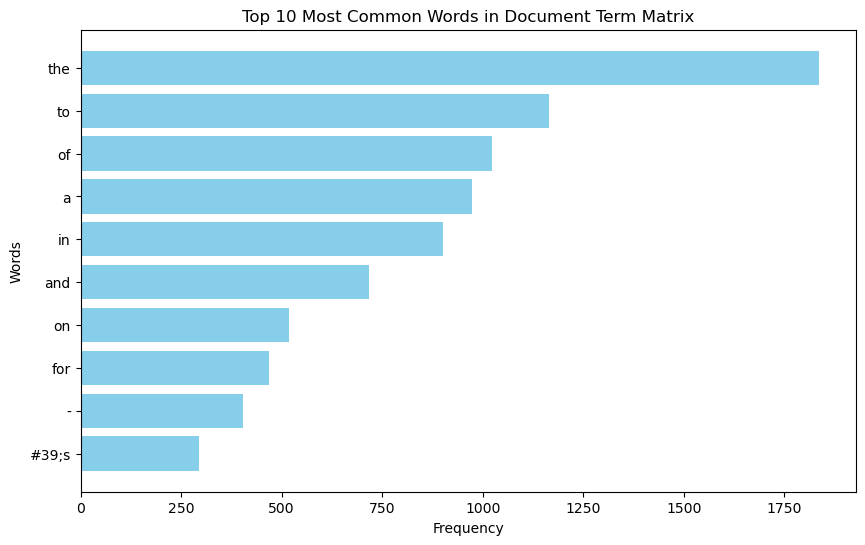

In [12]:
import numpy as np
import matplotlib.pyplot as plt


def visualize_top_n_tokens(n, document_term_matrix):

    # Sum the occurrences of each word across all documents
    word_counts = np.sum(document_term_matrix, axis=0)

    # Get the indices of the top n most common words
    top_n_indices = np.argsort(word_counts)[-n:]

    # Get the corresponding words and their counts
    top_n_words = [vocab[i] for i in top_n_indices]
    top_n_counts = word_counts[top_n_indices]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_words, top_n_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Common Words in Document Term Matrix')
    plt.show()

visualize_top_n_tokens(10, document_term_matrix)

In [ ]:
(X_train, X_val, y_train, y_val) = train_test_split(train_df["text"], train_df["label"], test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(960,) (240,) (960,) (240,)


In [15]:
# countvectorizer
cv = CountVectorizer()
X_train_vectorized = cv.fit_transform(X_train)

In [16]:
X_train_vectorized.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [106]:
param_grid = {
    'penalty':['l2'],
    'random_state': [42],
    'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1],
    'max_iter': [100, 1000, 2500, 5000],
}

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)

lr_clf = LogisticRegression()  # Note that we can set hyperparameters here

# Create the GridSearchCV object
clf = GridSearchCV(lr_clf, param_grid=param_grid, cv=3, verbose=True, n_jobs=-1)

# Fit the GridSearchCV object with the vectorized training data
best_clf = clf.fit(X_train_vectorized, y_train)

# Access the best estimator
best_estimator = best_clf.best_estimator_

# Print the best estimator
print(best_estimator)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
LogisticRegression(C=10.0, random_state=42)


In [107]:
lr_clf = LogisticRegression(C=10, random_state=42) # Note that we can set hyperparameters here

lr_clf.fit(X_train_vectorized, y_train)

LogisticRegression(C=10, random_state=42)

In [108]:
X_val_vectorized = cv.transform(X_val) # note that we use transform here, not fit_transform

y_pred = lr_clf.predict(X_val_vectorized)

In [109]:

print("Performance on the training set:")
print(classification_report(y_train, lr_clf.predict(X_train_vectorized), target_names=label_map.values()))

print("Performance on the validation set:")
print(classification_report(y_val, y_pred, target_names=label_map.values()))



Performance on the training set:
              precision    recall  f1-score   support

       World       1.00      1.00      1.00       238
      Sports       1.00      1.00      1.00       240
    Business       1.00      1.00      1.00       240
    Sci/Tech       1.00      1.00      1.00       242

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960

Performance on the validation set:
              precision    recall  f1-score   support

       World       0.77      0.71      0.74        62
      Sports       0.72      0.60      0.65        60
    Business       0.79      0.87      0.83        60
    Sci/Tech       0.78      0.90      0.83        58

    accuracy                           0.77       240
   macro avg       0.76      0.77      0.76       240
weighted avg       0.76      0.77      0.76       240



In [110]:
test_df_vectorized = cv.transform(test_df["text"])

print("Performance on the test set:")
print(classification_report(test_df["label"], lr_clf.predict(test_df_vectorized), target_names=label_map.values()))

Performance on the test set:
              precision    recall  f1-score   support

       World       0.72      0.72      0.72       190
      Sports       0.75      0.73      0.74       190
    Business       0.84      0.88      0.86       190
    Sci/Tech       0.81      0.79      0.80       190

    accuracy                           0.78       760
   macro avg       0.78      0.78      0.78       760
weighted avg       0.78      0.78      0.78       760



<H3>Reflections on hyperparameters:<h3>
To effectively tune the hyperparameters I implemented GridSearchCV to let me test all the possible parameter combinations. In doing this, I found that the parameter 'C' - being LogisticRegression's parameter which controls the strength of its regularization, lower meaning higher regularization - was the most important in achieving a more or less accurate result. In terms of the results, the model achieved an accuracy of 78% on the test dataset. 
